- Generate internal and boundary collocation points 
- since the problem is small, try automatic differentiation 
- Automatic differentiation didnt work, try symbolic approach 


In [2]:
using BenchmarkTools
using ForwardDiff
include("RBFunctions.jl")
using Plots
using Symbolics
using Latexify

In [3]:
@variables ϵ r x₁ x₂;
#r = sqrt(x₁^2 + x₂^2)
ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))    #sqrt(x₁^2 + x₂^2)
display(ϕ)
Dr = Differential(r)
#Lap(exprs) = (Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs)
#L(expression) = expand_derivatives(Dr(Dr(expression)) + Dr(expression)/r)
#w1 = simplify(expand_derivatives(Laplacian2(ϕ)))
#w2 = simplify(expand_derivatives(Dr(Dr(ϕ)) + Dr(ϕ)/r))
#display(w1)
#display(w2)
#ΔΔϕ = simplify(substitute(expand_derivatives(Lap(Lap(ϕ))), sqrt(x₁^2 + x₂^2) => r),expand=true)
∂₁ϕ = expand_derivatives(Differential(x₁)(ϕ))
∂₂ϕ = expand_derivatives(Differential(x₂)(ϕ))
∂₁₂ϕ = expand_derivatives((Differential(x₁)*Differential(x₂))(ϕ))
∂₂₂ϕ = expand_derivatives((Differential(x₂)*Differential(x₂))(ϕ))
∂₁₁ϕ = expand_derivatives((Differential(x₁)*Differential(x₁))(ϕ))
display(∂₁ϕ)
#LLΦ = L(L(ϕ))
∂₁ϕ = build_function(∂₁ϕ, [x₁, x₂], ϵ)
∂₁ϕ = eval(∂₁ϕ)
∂₂ϕ = build_function(∂₂ϕ, [x₁, x₂], ϵ)
∂₂ϕ = eval(∂₂ϕ)

∂₁₂ϕ  = build_function(∂₁₂ϕ , [x₁, x₂], ϵ)
∂₁₂ϕ  = eval(∂₁₂ϕ )

∂₂₂ϕ = build_function(∂₂₂ϕ, [x₁, x₂], ϵ)
∂₂₂ϕ = eval(∂₂₂ϕ)

∂₁₁ϕ = build_function(∂₁₁ϕ, [x₁, x₂], ϵ)
∂₁₁ϕ = eval(∂₁₁ϕ)
#@btime fff([1,1],0.5)
#fff(10,0.2)

exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

(-2//1)*x₁*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

#15 (generic function with 1 method)

In [16]:
function gaussian2(r;ϵ=0.5) # guassian RBF
    return exp(-1*r*r*ϵ*ϵ)
end

function Δgaussian2(r;ϵ=0.5)
    return 2*ϵ*ϵ*gaussian2(r,ϵ=ϵ)*(2*r*r*ϵ*ϵ-1) - 2*ϵ*ϵ*gaussian2(r,ϵ=ϵ)
end

function abc(x)
    gaussian2(sqrt(x[1]^2 + x[2]^2))
end

function Δ(func)
    first_d(x) = ForwardDiff.derivative(func,x)
    second_d(x) = ForwardDiff.derivative(first_d,x)
    function res(rr)
        r = max(abs(rr),1E-15)
        return second_d(r) + (1/r) * first_d(r)
    end
    return res
end

function ΔΔ(func)
    d1(x) = ForwardDiff.derivative(func,x)
    d2(x) = ForwardDiff.derivative(d1,x)
    d3(x) = ForwardDiff.derivative(d2,x)
    d4(x) = ForwardDiff.derivative(d3,x)
    function res(rr)
        r = max(abs(rr),1E-15)
        return d4(r) + (2/r)* d3(r) - (1/r^2)* d2(r) + (1/r^3)* d1(r)
    end
    return res
end
function ∂₁(func)
    d1(x) = ForwardDiff.derivative(func,x)
    function res(vec)
        x,y = vec
        r = max(norm(vec),1E-15)
        return (d1(r)*x)/r
    end
    return res
end
function ∂₂(func)
    d1(x) = ForwardDiff.derivative(func,x)
    function res(vec)
        x,y = vec
        r = max(norm(vec),1E-15)
        return (d1(r)*y)/r
    end
    return res
end
function ∂₁₁(func)
    d1(x) = ForwardDiff.derivative(func,x)
    d2(x) = ForwardDiff.derivative(d1,x)
    function res(vec)
        x,y = vec
        x= max(norm(x),1E-15)
        y= max(norm(y),1E-15)
        #r = max(norm(vec),1E-15)
        r = sqrt(x*x+y*y)
        return ((x^2)*d2(r))/(r^2) + ((y^2)*d1(r))/(r^3)
    end
    return res
end

function ∂₁₂(func)
    d1(x) = ForwardDiff.derivative(func,x)
    d2(x) = ForwardDiff.derivative(d1,x)
    function res(vec)
        x,y = vec
        r = max(norm(vec),1E-15)
        return (d2(r)/(r^2) - d1(r)/(r^3))*x*y
    end
    return res
end

function ∂₂₂(func)
    d1(x) = ForwardDiff.derivative(func,x)
    d2(x) = ForwardDiff.derivative(d1,x)
    function res(vec)
        x,y = vec
        x= max(norm(x),1E-15)
        y= max(norm(y),1E-15)
        #r = max(norm(vec),1E-15)
        r = sqrt(x*x+y*y)
        return ((y^2)*d2(r))/(r^2) + ((x^2)*d1(r))/(r^3)
    end
    return res
end

function RBF_evaluate(eval_points,domain_p,boundary_p,coefficients)
    T_ed = point_difference_tensor(eval_points,domain_p)
    T_eb = point_difference_tensor(eval_points,boundary_p)
    a1,a2,a3 = size(T_eb)
    A11 =  apply(∂₂₂(Δ(gaussian2)),T_ed)
    A12 = -apply(∂₁₂(Δ(gaussian2)),T_ed)
    A13 = -apply(∂₂₂(gaussian2),T_eb)
    A14 =  apply(∂₁₂(gaussian2),T_eb)

    A21 = -apply(∂₁₂(Δ(gaussian2)),T_ed)
    A22 =  apply(∂₁₁(Δ(gaussian2)),T_ed)
    A23 =  apply(∂₁₂(gaussian2),T_eb)
    A24 = -apply(∂₁₁(gaussian2),T_eb)

    A31 = -apply(∂₁(gaussian2),T_ed)
    A32 = -apply(∂₂(gaussian2),T_ed)
    A33 = zeros((a1,a2))
    A34 = zeros((a1,a2))

    output = zeros((3,size(eval_points)[2]))
    output[1,:] = [A11 A12 A13 A14] * coefficients
    output[2,:] = [A21 A22 A23 A24] * coefficients
    output[3,:] = [A31 A32 A33 A34] * coefficients
    #display(output)
    return output
end

function true_velocity(x,y)
    return [20*x*y^3  5*x^4 - 5*y^4]
end
function true_pressure(x,y)
    return 60*x*x*y - 20*y^3 
end
#Δ(Δ(abc))([5,2])


true_pressure (generic function with 1 method)

4.218464960028751
4.218464960028751
here:  49.5
0.1516326649281583
49.5



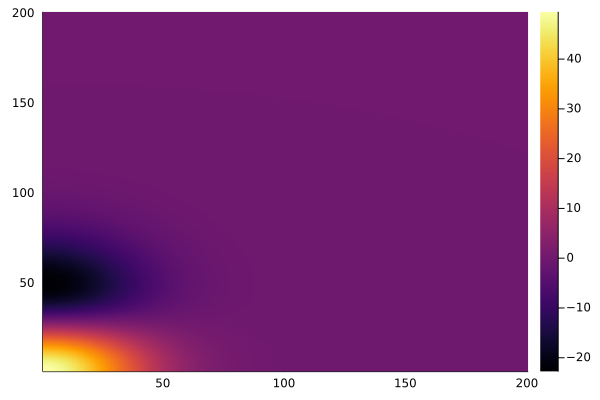

In [17]:
ZZ  =200
tst1 = [∂₁(gaussian2)([i,j]) for i=LinRange(0,1,100),j=LinRange(0,1,100) ]
tst2 = [∂₁ϕ([i,j],5) for i=LinRange(0,1,100),j=LinRange(0,1,100)]
println(maximum(tst1-tst2))

tst3 = [∂₂(gaussian2)([i,j]) for i=LinRange(0,1,100),j=LinRange(0,1,100) ]
tst4 = [∂₂ϕ([i,j],5) for i=LinRange(0,1,100),j=LinRange(0,1,100)]
println(maximum(tst3-tst4))


tst5 = [∂₁₁(gaussian2)([i,j]) for i=LinRange(0,1,ZZ),j=LinRange(0,1,ZZ) ]
tst6 = [∂₁₁ϕ([i,j],5) for i=LinRange(0,1,ZZ),j=LinRange(0,1,ZZ)]
println("here:  ",maximum(tst5-tst6))

tst7 = [∂₁₂(gaussian2)([i,j]) for i=LinRange(0,1,100),j=LinRange(0,1,100) ]
tst8 = [∂₁₂ϕ([i,j],5) for i=LinRange(0,1,100),j=LinRange(0,1,100)]
println(maximum(tst7-tst8))

tst9 = [∂₂₂(gaussian2)([i,j]) for i=LinRange(0,1,100),j=LinRange(0,1,100) ]
tst10 = [∂₂₂ϕ([i,j],5) for i=LinRange(0,1,100),j=LinRange(0,1,100)]
println(maximum(tst9-tst10))

println(tst5-tst6)
heatmap(tst5-tst6)


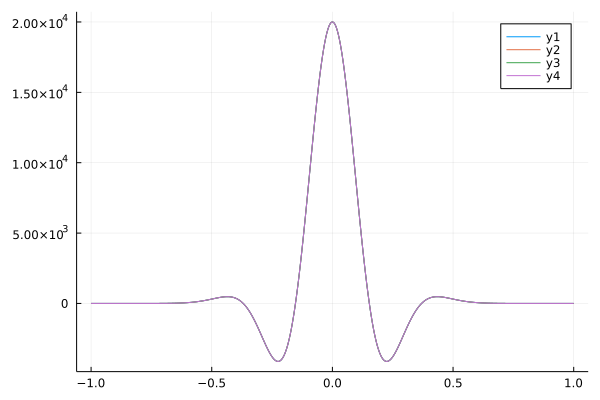

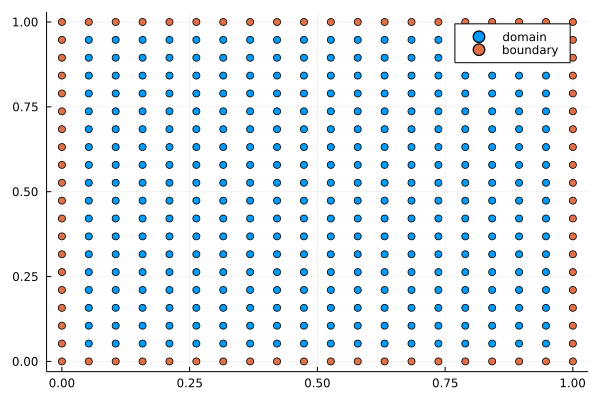

In [18]:
# generate points 
include("RBFunctions.jl")
domain_p, boundary_p = generate_2D_equally_spaced_points(20)
N_domain = size(domain_p)[2]
N_boundary = size(boundary_p)[2]
all_points = [domain_p boundary_p]
scatter(domain_p[1,:],domain_p[2,:],label="domain")
scatter!(boundary_p[1,:],boundary_p[2,:],label="boundary")



In [28]:
T_dd = point_difference_tensor(domain_p,domain_p)
T_db = point_difference_tensor(domain_p,boundary_p)
T_bb = point_difference_tensor(boundary_p,boundary_p)

A11 = -apply(∂₁₁(gaussian2),T_dd) - apply(∂₂₂(ΔΔ(gaussian2)),T_dd)
A12 = apply(∂₁₂(ΔΔ(gaussian2)),T_dd) - apply(∂₁₂(gaussian2),T_dd)
A13 = apply(∂₂₂(Δ(gaussian2)),T_db)
A14 = -apply(∂₁₂(Δ(gaussian2)),T_db)
A22 = -apply(∂₁₁(ΔΔ(gaussian2)),T_dd) - apply(∂₂₂(gaussian2),T_dd)
A23 = -apply(∂₁₂(Δ(gaussian2)),T_db)
A24 =  apply(∂₁₁(Δ(gaussian2)),T_db)
A33 = -apply(∂₂₂(gaussian2),T_bb)
A34 = apply(∂₁₂(gaussian2),T_bb)
A44 = -apply(∂₁₁(gaussian2),T_bb)
A = [A11  A12  A13  A14
    A12' A22  A23  A24
    A13' A23' A33  A34
    A14' A24' A34' A44]
#A = Symmetric(A)
println("condition number of A: ",cond(A))
println("max element of A: ", maximum(A))
g = [true_velocity(boundary_p[1,i],boundary_p[2,i])[j] for j = 1:2 , i=1:size(boundary_p)[2]]
F = zeros(size(domain_p)[2]*2)
F = vcat(F,g[1,:],g[2,:])
coef = A\F
#println("finished")
#p1 = heatmap(A)
#plot(p1, size =(700,600))
display(A[1:20,1:20])

condition number of A: 9.604113642987759e52
max element of A: 3.059579765336471e43


20×20 Matrix{Float64}:
 3.05958e43  3.4872      3.44895     …  0.679761    3.49481     3.48202
 3.4872      3.05958e43  3.4872         0.923224    3.48202     3.49481
 3.44895     3.4872      3.05958e43     1.16833     3.44382     3.48202
 3.38567     3.44895     3.4872         1.41271     3.38062     3.44382
 3.29809     3.38567     3.44895        1.65393     3.29314     3.38062
 3.18719     3.29809     3.38567     …  1.88955     3.18237     3.29314
 3.05421     3.18719     3.29809        2.11712     3.04954     3.18237
 2.90063     3.05421     3.18719        2.33427     2.89615     3.04954
 2.72816     2.90063     3.05421        2.53868     2.72388     2.89615
 2.53868     2.72816     2.90063        2.72816     2.53463     2.72388
 2.33427     2.53868     2.72816     …  2.90063     2.33047     2.53463
 2.11712     2.33427     2.53868        3.05421     2.11358     2.33047
 1.88955     2.11712     2.33427        3.18719     1.88628     2.11358
 1.65393     1.88955     2.11712        3

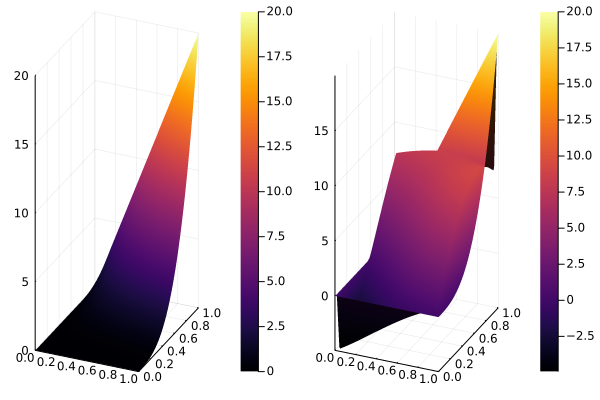

In [125]:
numerical_solution = RBF_evaluate(all_points,domain_p,boundary_p,coef)
true_solution = [true_velocity(all_points[1,i],all_points[2,i])[j] for j = 1:2 , i=1:size(all_points)[2]]

p1 = surface(all_points[1,:],all_points[2,:],true_solution[1,:])
p2 = surface(all_points[1,:],all_points[2,:],numerical_solution[1,:])
#print(numerical_solution)
plot(p1, p2, layout=(1,2), legend=false)

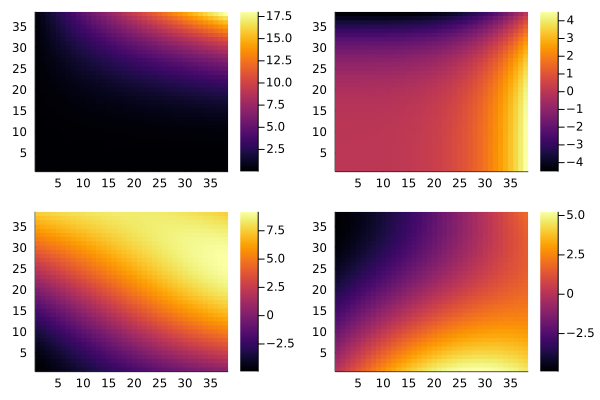

In [123]:
bbb = floor(Int64,sqrt(N_domain))
true1 = permutedims(reshape(true_solution[1,1:N_domain],(bbb,bbb)),(1,2))
true2 = permutedims(reshape(true_solution[2,1:N_domain],(bbb,bbb)),(1,2))
numerical1 = permutedims(reshape(numerical_solution[1,1:N_domain],(bbb,bbb)),(1,2))
numerical2 = permutedims(reshape(numerical_solution[2,1:N_domain],(bbb,bbb)),(1,2))
p1 = heatmap(true1)
p2 = heatmap(true2)
p3 = heatmap(numerical1)
p4 = heatmap(numerical2)
plot(p1, p2, p3, p4, layout=(2,2), legend=false)